In [81]:
import numpy as np
from icecream import ic
from copy import deepcopy
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [82]:
# Total value of selected items
def V(solution: np.ndarray) -> int:
    return VALUES[np.any(solution, axis=0)].sum()

# Penalty for invalid knapsacks calculation (excess weight)
def P(solution):
    penalty = 0
    for k in range(NUM_KNAPSACKS):
        total_weight = WEIGHTS[solution[k]].sum(axis=0)
        excess_weight = total_weight - CONSTRAINTS[k]
        penalty += np.sum(excess_weight[excess_weight > 0])
    return penalty

# Penalty for duplicated items as number duplicate times value
def D(solution: np.ndarray) -> int:
    total_selected = solution.sum(axis=0)
    duplicates = total_selected[total_selected > 1]
    return np.sum(duplicates * VALUES[total_selected > 1])

In [83]:
# Cost as Penalty + Duplicate Penalty - Value
def cost(solution):
    return (P(solution)+D(solution))-V(solution)


def tweak(solution: np.ndarray, strength: float) -> np.ndarray:
    new_solution = deepcopy(solution)

    again = True

    while again:
        # Avoid computing multiple times P and D
        d_val = D(new_solution)
        p_val = P(new_solution)

        if d_val > 0: # There are duplicated items
            # Remove duplicates except for one knapsack, for each duplicated item
            duplicated_items = np.where(new_solution.sum(axis=0) > 1)[0]
            
            # For each duplicated item, randomly keep it in one knapsack and remove from others
            for item in duplicated_items:
                knapsacks_with_item = np.where(new_solution[:, item])[0]
                knapsacks_to_remove_from = rng.choice(knapsacks_with_item, size=len(knapsacks_with_item)-1, replace=False)
                for k in knapsacks_to_remove_from:
                    new_solution[k, item] = False

        if p_val > 0: # There are overweight knapsacks
            overweight_knapsacks = [k for k in range(NUM_KNAPSACKS) if np.any(WEIGHTS[new_solution[k]].sum(axis=0) > CONSTRAINTS[k])]

            for k in overweight_knapsacks:
                overweight = True

                while overweight:
                    # Select item with worst value/weight ratio
                    item_indices = np.where(new_solution[k])[0]
                    if len(item_indices) == 0:
                        break
                    value_weight_ratios = VALUES[item_indices] / np.maximum(WEIGHTS[item_indices].sum(axis=1), 1)
                    worst_item_index = item_indices[np.argmin(value_weight_ratios)]
                    new_solution[k, worst_item_index] = False
                    if np.all(WEIGHTS[new_solution[k]].sum(axis=0) <= CONSTRAINTS[k]):
                        overweight = False

        if d_val == 0 and p_val == 0:
            # If no penalties, swap add/remove an item
            knapsack_idx = rng.integers(0, NUM_KNAPSACKS)
            item_idx = rng.integers(0, NUM_ITEMS)
            new_solution[knapsack_idx, item_idx] = not new_solution[knapsack_idx, item_idx]


        again = np.random.rand() < strength if p_val > 0 or d_val > 0 else False
    return new_solution



In [84]:
# Initialize solution with random assignments
def initial_solution() -> np.ndarray:
    return np.array(
    [np.random.random(NUM_ITEMS) < 0.5 for _ in range(NUM_KNAPSACKS)], dtype=np.bool
    )

# Solver
def solve(solution: np.ndarray, max_iter: int=1000, strength: float=0.3, temperature: float=100) -> np.ndarray:
    current_solution = deepcopy(solution)
    best_solution = deepcopy(solution)
    best_cost = cost(current_solution)
    current_cost = best_cost

    current_d = D(current_solution)
    current_p = P(current_solution)

    cost_history = [current_cost]
    best_cost_history = [best_cost]

    for step in tqdm(range(max_iter)):
        new_solution = tweak(current_solution, strength)
        new_cost = cost(new_solution)

        new_d = D(new_solution)
        new_p = P(new_solution)

        better_penalties = (new_d <= current_d) or (new_p <= current_p)
        solution_feasible = (new_d == 0) and (new_p == 0)

        if not better_penalties:
            temperature *= 0.99
            cost_history.append(current_cost)
            best_cost_history.append(best_cost)
            continue

        if solution_feasible and new_cost < best_cost:
            best_solution = deepcopy(new_solution)
            best_cost = new_cost


        if new_cost <= current_cost:
            current_solution = deepcopy(new_solution)
            current_cost = new_cost
            current_d = new_d
            current_p = new_p
        elif np.random.rand() < np.exp((current_cost - new_cost) / temperature):
            current_solution = deepcopy(new_solution)
            current_cost = new_cost
            current_d = new_d
            current_p = new_p

        cost_history.append(current_cost)
        best_cost_history.append(best_cost)


        temperature *= 0.99
    best_value = V(best_solution)
    return best_solution, best_cost, best_value, cost_history, best_cost_history
    

In [85]:
def plot_cost_history(cost_history, best_cost_history):

    plt.plot(cost_history, label='Current Cost')
    plt.plot(best_cost_history, label='Best Cost', linestyle='--')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.title('Cost History')
    plt.legend()
    plt.grid()
    plt.show()

# Test problems

In [86]:
# Problem 1
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 3
NUM_ITEMS = 20
NUM_DIMENSIONS = 2
VALUES = rng.integers(0, 100, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS))

100%|██████████| 5000/5000 [00:01<00:00, 2678.09it/s]
ic| best_cost: np.int64(-1065)
    best_value: np.int64(1065)
    feasible_sol: np.True_


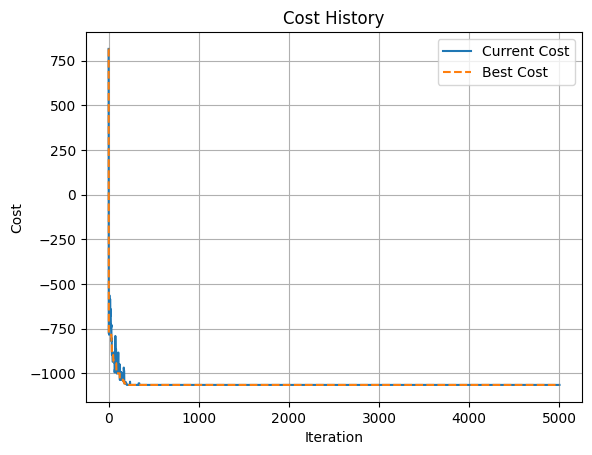

In [87]:
sol, best_cost, best_value, cost_history, best_cost_history = solve(initial_solution(), max_iter=5000, strength=0.3, temperature=100)
feasible_sol = (D(sol) == 0) and (P(sol) == 0)
ic(best_cost, best_value, feasible_sol)
plot_cost_history(cost_history, best_cost_history)

In [88]:
# Problem 2
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 10
NUM_ITEMS = 100
NUM_DIMENSIONS = 10
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(1000 * 2, 1000 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS))

100%|██████████| 5000/5000 [00:05<00:00, 982.90it/s] 
ic| best_cost: np.int64(-35785)
    best_value: np.int64(35785)
    feasible_sol: np.True_


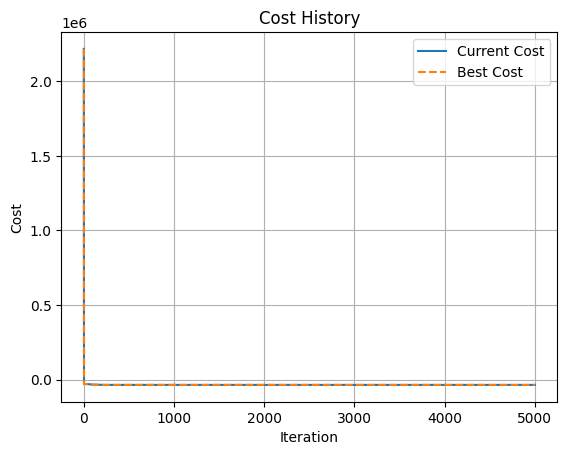

In [89]:
sol, best_cost, best_value, cost_history, best_cost_history = solve(initial_solution(), max_iter=5000, strength=0.3, temperature=100)
feasible_sol = (D(sol) == 0) and (P(sol) == 0)
ic(best_cost, best_value, feasible_sol)
plot_cost_history(cost_history, best_cost_history)

In [90]:
# Problem 3
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 100
NUM_ITEMS = 5000
NUM_DIMENSIONS = 100
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(1000 * 10, 1000 * 2 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS))

100%|██████████| 5000/5000 [01:37<00:00, 51.37it/s]
ic| best_cost: np.int64(-1590118)
    best_value: np.int64(1590118)
    feasible_sol: np.True_


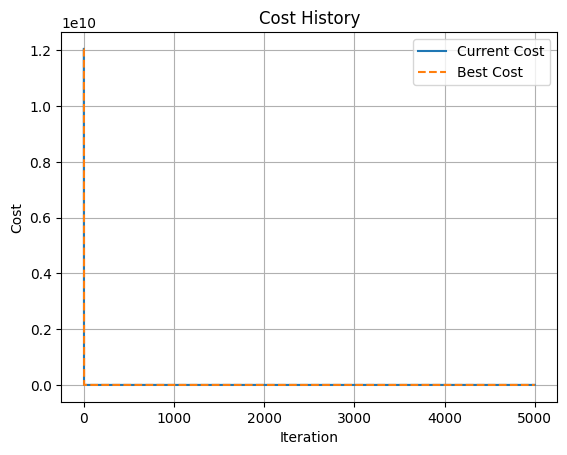

In [91]:
sol, best_cost, best_value, cost_history, best_cost_history = solve(initial_solution(), max_iter=5000, strength=0.3, temperature=100)
feasible_sol = (D(sol) == 0) and (P(sol) == 0)
ic(best_cost, best_value, feasible_sol)
plot_cost_history(cost_history, best_cost_history)